In [1]:
from datetime import timedelta, date
from collections import Counter 
import numpy as np 
import matplotlib.pyplot as plt 
from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go
from plotly import tools

init_notebook_mode(connected=True) 
%matplotlib inline 

### Approach #2: Trigonometric regression model  

Part 2 continues the attempt to reduce the number of parameters in our equation, but this time using a model based approach rather than a Fourier transform.

We start by reproducing our time series.

In [2]:
def is_prime_wed(date):
    return (date.day in {2,3,5,7,11,13,17,19,23,29,31}) & (date.weekday() == 2)

def count_prime_weds(year):
    start_date = date(year, 1, 1)
    end_date = date(year, 12, 31)
    
    dates = [start_date + timedelta(n) for n in range((end_date - start_date).days + 1)] 
    
    return sum(1 for date in dates if is_prime_wed(date))

In [3]:
start_year = 1912
end_year = 2233
years = range(start_year, end_year + 1)

prime_weds = [count_prime_weds(year) for year in range(start_year, end_year + 1)]

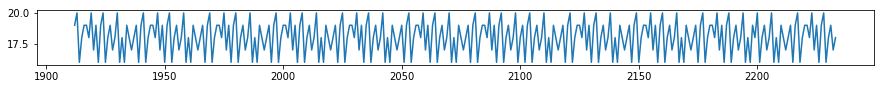

In [44]:
plt.figure(figsize=(15, 1))
plt.plot(years, prime_weds) 
plt.show()

Re-creating scaled dependant/independant variables for our model, this time we will double the size of our input data to avoid issues with n-observations ~ n-features.

In [46]:
y = np.tile(np.array(prime_weds), 2)
sf = end_year - start_year + 1  # sample frequency
x = np.arange(len(y)) / sf

Currently we only have one independant variable for our model: `x` which represents the year (but has been scaled between 0-1)

As the relationship between `x` and `y` is clearly non-linear we will get a terrible fit using just one variable. 

To generate more independant variables we can transform `x`. We could create a polynomial series e.g. `c₁x + c₂x^2 + c₃x^3...` but for this task it makes more sense to use a trigonometric series `c₁sin(x) + c₂sin(2x) + c₃sin(3x)...`, for the reasons stated in part 1 of the notebook.

Here, each `c` is a coefficient which we will try to optimise, and each transform of x is a parameter in our model. We are trying to produce the simplest model, that is, the one with the fewest parameters.

In [47]:
def sine_transform(x, freq):
    ''' generate sine waves of specified frequencies from time series array '''
    return np.sin(freq * x * 2*np.pi)

Here we have defined out sine transform which we use to "generate" features for our model. Each feature will be the same transform with a different frequency, and the amplitude of each frequency will be the coefficient we will try to learn in the model. Plotting examples of different frequencies below (fixed amplitude)

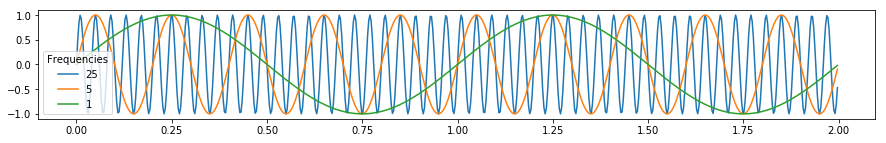

In [50]:
plt.figure(figsize=(15,2))

freqs = [25, 5, 1]
for freq in freqs:
    plt.plot(x, sine_transform(x, freq), label=str(freq))
    plt.legend(title='Frequencies', loc='lower left')
plt.show()

We can also define a cosine transformation, this is the same as sine but with a 90 degrees phase shift and should hopefully give us some more flexibility when we try to fit the model 

In [51]:
def cosine_transform(x, freq):
    ''' generate cosine waves of specified frequencies from time series array '''
    return np.cos(freq * x * 2*np.pi)

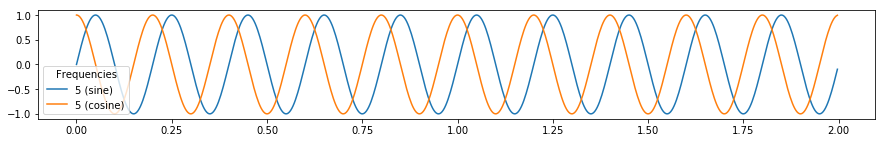

In [52]:
plt.figure(figsize=(15,2))
plt.plot(x, sine_transform(x, 5), label=str(5) + ' (sine)')
plt.plot(x, cosine_transform(x, 5), label=str(5) + ' (cosine)')
plt.legend(title='Frequencies', loc='lower left')
plt.show()

Generating input data for model, by defining sine and cosine transformations for frequencies between 2 and 161 (nyquist). We start at 2 as the model will have a perfect fit otherwise and the p-values will be meaningless (and cannot be used to trim the model) 

In [67]:
freqs = range(1, 162)
transforms = []
feature_names = []
for freq in freqs:
    transforms.append(sine_transform(x, freq))
    feature_names.append('sin' + str(freq))
    transforms.append(cosine_transform(x, freq))
    feature_names.append('cos' + str(freq))

Add "bias" (intercept) term

In [68]:
transforms.insert(0, np.ones(len(x)))
feature_names.insert(0, 'bias')

Define final array containing all features

In [69]:
X = np.array(transforms).T
X.shape

(644, 323)

In [70]:
import statsmodels.api as sm

In [71]:
residual_max = 0
feature_mask = np.full(X.shape[1], True)
feature_mask[1] = False 
while residual_max < 0.5:
    results = sm.OLS(y, X[:, feature_mask]).fit()
    residual_max = abs(results.resid).max()
    print(sum(feature_mask))
    print(residual_max)
    print(results.rsquared_adj)
    excluded_feature = results.pvalues.argmax() # find feature with largest p-value
    print('Exclude:', feature_names[excluded_feature])
    feature_mask[excluded_feature] = False   

322
0.00687569739922
0.999974629555
Exclude: cos160
321
0.0199867736003
0.999816223239
Exclude: cos24
320
0.0466891627247
0.999380235859
Exclude: cos50
319
0.0563648920374
0.999328601944
Exclude: cos75
318
0.0587522658095
0.999318062797
Exclude: sin75
317
0.0691546716954
0.999215527563
Exclude: cos74
316
0.0673120037939
0.999189435299
Exclude: sin74
315
0.0667508965789
0.999191302642
Exclude: cos73


LinAlgError: SVD did not converge

In [23]:
np.where(feature_mask).shape

AttributeError: 'tuple' object has no attribute 'shape'

## np.full(X.shape[1], True)

In [16]:
X[:, ~[3,4]].shape

TypeError: bad operand type for unary ~: 'list'

In [ ]:
X.shape

In [ ]:
print(results.summary())

In [ ]:
results.pvalues.argmax()

In [ ]:
feature_names[102]

In [ ]:
abs(results.resid).max()